<a href="https://colab.research.google.com/github/lipiecki/energy-analytics-2025/blob/main/notebooks/DieboldMariano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing for equal predictive performance with the Diebold-Mariano test

In [1]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load one of the included datasets - EPEX or GEFCom

In [2]:
dataset = "epex" # "epex" or "gefcom"
url = f"https://raw.githubusercontent.com/lipiecki/energy-analytics-2025/refs/heads/main/data/{dataset}.csv"
local = f"../data/{dataset}.csv"

In [3]:
df = pd.read_csv(url, delimiter=',', header=0, index_col=[0, 1]) # use `local` instead or `url` when running the notebook offline
df.head()

price   load_da  load_real  day_of_week
date     hour                                         
20220101 0     50.05  41989.50   43915.50            6
         1     41.33  40105.50   41535.75            6
         2     43.22  38784.00   40480.75            6
         3     45.46  37751.00   39564.00            6
         4     37.67  37877.25   39338.25            6

### Prepare the explanatory variables for the regression models

In [4]:
# create lag columns for prices from previous days
df['lag1'] = df['price'].shift(24)  # price one day ago (24 hours)
df['lag2'] = df['price'].shift(48)  # price two days ago (48 hours)
df['lag7'] = df['price'].shift(168) # price seven days ago (168 hours)
df.dropna(inplace=True)
df

price   load_da  load_real  day_of_week    lag1    lag2  \
date     hour                                                             
20220108 0     164.17  51093.00   52694.75            6  128.92   99.85   
         1     152.83  49105.50   50532.50            6  118.40  101.32   
         2     166.00  48075.25   49608.25            6  103.01  110.01   
         3     160.86  47763.50   49543.25            6  101.91  111.55   
         4     160.00  47900.25   49077.25            6  101.98  123.37   
...               ...       ...        ...          ...     ...     ...   
20241231 19    200.00  56083.25   54868.50            2  165.93  206.72   
         20    204.61  53423.00   51940.50            2  184.44  194.97   
         21    186.25  50937.50   50559.50            2  203.88  195.95   
         22    146.52  47657.50   49133.50            2  168.46  167.31   
         23    141.68  45257.25   49607.50            2  162.92  149.98   

                 lag7  
date     hour          
20220108 0      50.05  
         1      41.33  
         2      43.22  
         3      45.46  
         4      37.67  
...               ...  
20241231 19    105.66  
         20    102.56  
         21     94.63  
         22     99.04  
         23     90.00  

[26136 rows x 7 columns]

### Generate naive forecasts
Take the price from one day ago or a week ago, depending on the day of the week

In [5]:
# function to generate forecast based on current day of the week
def generate_naive(row):
    if row['day_of_week'] > 1 and row['day_of_week'] <= 5:  # Tuesday to Friday
        return row['lag1']
    else:  # Saturday to Monday
        return row['lag7']

# apply the function to each row to generate the naive forecast
df['naive_forecast'] = df.apply(generate_naive, axis=1)

### Define functions for the Holt-Winters exponential smoothing model

In [6]:
# Holt-Winters function definitions
def holtwinters(params, s, obs):
    """
    Calculates forecasts using Holt-Winters exponential smoothing.

    Args:
        params (tuple): parameters in the form of a 3-tuple (alpha, beta, gamma)
        s (int): seasonality period
        obs (1d numpy array): observed values of the timeseries to forecast

    Returns:
        2-tuple of 1d numpy arrays: first element is the array of forecasts, second is the array of corresponding observations
    """
    alpha, beta, gamma = params
    level = np.zeros(len(obs))
    trend = np.zeros(len(obs))
    season = np.zeros(len(obs))
    forecast = np.zeros(len(obs))

    # set initial values
    level[s-1] = np.mean(obs[:s])
    trend[s-1] = (np.mean(obs[s:2*s]) - np.mean(obs[:s]))/s
    season[:s] = obs[:s] - level[s-1]

    # iteratively compute consecutive forecasts
    for t in range(s, len(obs)-1):
        level[t] = alpha*(obs[t] - season[t-s]) + (1-alpha)*(level[t-1] + trend[t-1])
        trend[t] = beta*(level[t] - level[t-1]) + (1-beta)*trend[t-1]
        season[t] = gamma*(obs[t] - level[t]) + (1-gamma)*season[t-s]
        forecast[t+1] = level[t] + trend[t] + season[t-s+1]

    # return forecasts starting from the (2s+1)-th timestep
    return forecast[2*s:]

def loss_hw(params, s, obs):
    """
    Calculates mean squared error of forecasts from `holtwinters(params, s, obs)`.
    """
    forecasts = holtwinters(params, s, obs)
    return mean_squared_error(forecasts, obs[2*s:])

def calibrate_hw(s, obs):
    """
    Find optimal values of `params` for `holtwinters(params, s, obs)`
    """
    opt_params = optimize.minimize(loss_hw, (0.5, 0.5, 0.5), args = (s, obs), bounds = ((0, 1), (0, 1), (0, 1)))
    return opt_params.x

### Specify the parameters for forecasting models

In [7]:
season = 7
window = 358

### Prepare the input and output data for forecasting models

In [8]:
hour = 19
df = df[[df.index[i][1] == hour for i in range(len(df))]].copy()
X = np.array(df[['lag1', 'lag2', 'lag7']])
Y = np.array(df['price'])

### Generate forecasts with the AR and HW models

In [9]:
df['ar_forecast'] = np.nan
df['hw_forecast'] = np.nan
for i in range(window, len(df)):
      # AR model
      X_window = X[i-window:i, :]
      Y_window = Y[i-window:i]
      ar = LinearRegression().fit(X_window, Y_window)
      df.iloc[i, df.columns.get_loc('ar_forecast')] = ar.predict([X[i, :]])

      # HW model
      optimal_params = calibrate_hw(season, Y_window)
      df.iloc[i, df.columns.get_loc('hw_forecast')] = holtwinters(optimal_params, season, np.hstack((Y_window, Y[i])))[-1]

### Remove days without forecasts

In [10]:
df.dropna(inplace=True)
df

,,price,load_da,load_real,day_of_week,lag1,lag2,lag7,naive_forecast,ar_forecast,hw_forecast
date,hour,,,,,,,,,,
20230101,19,54.95,48131.75,47391.25,7,-1.01,13.79,110.09,110.09,41.329874,-27.051735
20230102,19,164.46,62431.75,59401.00,1,54.95,-1.01,59.17,59.17,76.798494,102.508728
20230103,19,160.99,63632.50,59620.00,2,164.46,54.95,156.93,164.46,179.174676,175.700309
20230104,19,66.61,64663.75,64179.50,3,160.99,164.46,71.77,160.99,154.223589,155.151377
20230105,19,177.98,65850.75,59456.75,4,66.61,160.99,47.94,66.61,74.976914,109.466880
...,...,...,...,...,...,...,...,...,...,...,...
20241227,19,146.43,52284.00,55356.25,5,135.71,118.14,129.00,135.71,139.308567,90.061067
20241228,19,126.87,52479.75,54171.50,6,146.43,135.71,145.83,145.83,149.153567,89.181260
20241229,19,206.72,50431.00,54677.75,7,126.87,146.43,159.19,159.19,140.394251,99.361308


### Implement the Diebold-Mariano test

In [11]:
# Diebold-Mariano function definition
def DM(obs, forecast1, forecast2):

    # compute the loss differential series
    loss_diff = np.abs(obs - forecast1) - np.abs(obs - forecast2)

    # calculate the test statistic
    mu = np.mean(loss_diff)
    sigma = np.std(loss_diff, ddof=1)
    z = np.sqrt(loss_diff.size)*mu/sigma

    pvalue = 1 - norm.cdf(z)

    return pvalue

### Calculate the DM test matrix

In [12]:
forecasts = ['naive', 'ar', 'hw']
pvalue_matrix = np.empty((3, 3))
for f1 in range(len(forecasts)):
  for f2 in range(len(forecasts)):
      if f1 != f2:
        pvalue_matrix[f1, f2] = DM(np.array(df['price']),
                                df[forecasts[f1]+"_forecast"],
                                df[forecasts[f2]+"_forecast"])
      else:
        pvalue_matrix[f1, f2] = np.nan

### Plot the DM test matrix

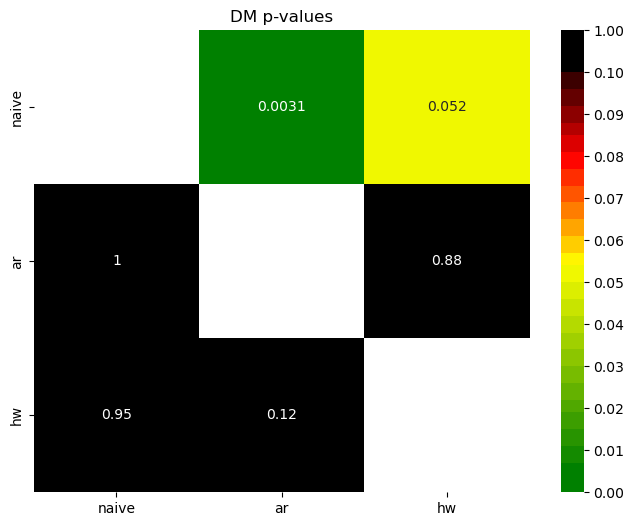

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 'green'), (0.05, 'yellow'), (0.075, 'red'), (0.1, 'black'), (1, 'black')]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# create the heatmap of p-values from the DM test
plt.figure(figsize=(8, 6))
sns.heatmap(pvalue_matrix, annot=True, cmap=cmap,
            cbar_kws={'boundaries': [i/1000 for i in range(0, 101)] + [1]*10, 'ticks': [i/1000 for i in range(0, 101, 10)] + [1]},
            xticklabels=forecasts, yticklabels=forecasts)
plt.title("DM p-values")
plt.show()

### Print MAE of the forecasts

In [14]:
print("-"*30)
print("Mean Absolute Error")
print("-"*30)
print(f"AR: {mean_absolute_error(df['price'], df['ar_forecast'])}")
print(f"HW: {mean_absolute_error(df['price'], df['hw_forecast'])}")
print(f"Naive: {mean_absolute_error(df['price'], df['naive_forecast'])}")

------------------------------
Mean Absolute Error
------------------------------
AR: 33.99276003639692
HW: 35.25777402119037
Naive: 37.51248974008209
